In [ ]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import torch 
import torch.nn as nn
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
torch.manual_seed(0)
np.random.seed(0)
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load Data

In [ ]:
## season 2 dataframes 
train_x_2 = pd.read_csv('./drive/MyDrive/bitTrader2/train_x_df.csv')
train_y_2 = pd.read_csv('./drive/MyDrive/bitTrader2/train_y_df.csv') 
test_x_2 = pd.read_csv('./drive/MyDrive/bitTrader2/test_x_df.csv') 
submission = pd.read_csv('./drive/MyDrive/bitTrader2/sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [ ]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [ ]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [ ]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [ ]:
y_train_close = y_train[:,:,4]
x_train_close = x_train[:,:,4].reshape((-1,1380)) 
x_test_close = x_test[:,:,4].reshape((-1,1380))

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1)
close_prices.shape


(7661, 1500)

# Preprocess Data

Given time series data (t_1, t_2, ..., t_N) predict t_{N+K} 
Here, we let K = 120 and N is a hyperparameter, but we can let it be 60 minutes. 

In [ ]:
K = 120 
N = 60 # get 60 minute data 
seq_len = 1500 
X = [] 
Y = [] 

for j in tqdm(range(close_prices.shape[0]), position = 0, leave = True):   
    i = 0
    while i+N+K < 1500: 
        X.append(close_prices[j, i:i+N]) 
        Y.append(close_prices[j, i+N+K]) 
        i += 1 

X = np.asarray(X) 
Y = np.asarray(Y) 

X.shape, Y.shape

100%|██████████| 7661/7661 [00:10<00:00, 758.50it/s]


((10112520, 60), (10112520,))

In [ ]:
X = X.reshape((-1,N,1)) # (batch_size, timesteps, num_features)
X.shape

(10112520, 60, 1)

# Train Transformer


In [ ]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 2, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    
def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2): 
    inputs = Input((N, 1))
    bn = BatchNormalization()(inputs)
    x = Conv1D(node*2, 5, activation = activation)(bn) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    
    x = transformer_block(x, node, drop_rate, activation)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(drop_rate)(x)
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=inputs,outputs=x) 
    model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae','mape']) 
    return model 

In [ ]:
## build model 
def build_model(): 
    inputs = Input((N,1)) # (batch_size, timesteps, features)
    bn = BatchNormalization()(inputs)
    gru = GRU(128, return_sequences = True)(bn)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = True)(gru)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = False)(gru)  
    dense = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(gru) 
    dense = BatchNormalization()(dense) 
    outputs = Dense(1, activation = 'relu')(dense) 
    model = Model(inputs=inputs, outputs = outputs) 
    model.compile(loss='mse', optimizer = 'adam', metrics = ['mae', 'mape'])
    return model 

In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 1)             4         
_________________________________________________________________
gru (GRU)                    (None, 60, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072 

In [ ]:
model = build_model() 


model_path = './drive/MyDrive/bitTrader2/GRU_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                   Y, 
                   batch_size = 32, ## avoid OOM 
                   epochs = 100, 
                   callbacks = [learning_rate_reduction, checkpoint, early_stopping], 
                   validation_split = 0.1)


Epoch 1/100
284415/284415 [==============================] - 3503s 12ms/step - loss: 0.0015 - mae: 0.0163 - mape: 1.6226 - val_loss: 0.0016 - val_mae: 0.0367 - val_mape: 3.6550

Epoch 00001: val_loss improved from inf to 0.00164, saving model to ./drive/MyDrive/bitTrader2/GRU_epoch_001_val_0.002.h5
Epoch 2/100
284415/284415 [==============================] - 3598s 13ms/step - loss: 3.5692e-04 - mae: 0.0124 - mape: 1.2431 - val_loss: 5.0378e-04 - val_mae: 0.0124 - val_mape: 1.2438

Epoch 00002: val_loss improved from 0.00164 to 0.00050, saving model to ./drive/MyDrive/bitTrader2/GRU_epoch_002_val_0.001.h5
Epoch 3/100
284415/284415 [==============================] - 3687s 13ms/step - loss: 3.0672e-04 - mae: 0.0116 - mape: 1.1573 - val_loss: 4.1748e-04 - val_mae: 0.0124 - val_mape: 1.2393

Epoch 00003: val_loss improved from 0.00050 to 0.00042, saving model to ./drive/MyDrive/bitTrader2/GRU_epoch_003_val_0.000.h5
Epoch 4/100
284415/284415 [==============================] - 3718s 13ms/step

KeyboardInterrupt: ignored

# Make Prediction

In [ ]:
best_gru = load_model('./drive/MyDrive/bitTrader2/GRU_epoch_003_val_0.000.h5')

In [ ]:
## We need to preprocess inputs for prediction 
X_test = [] 
for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
  for i in range(seq_len-N-K-120, seq_len-N-K):
    X_test.append(x_test_close[j, i:i+N])  

X_test = np.asarray(X_test).reshape((-1,N,1))

100%|██████████| 535/535 [00:00<00:00, 15136.38it/s]


In [ ]:
X_test.shape 

(64200, 60, 1)

In [ ]:
predicted = best_gru.predict(X_test) 
predicted = predicted.reshape((-1,120)) 

In [ ]:
## create submission dataframe 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
  sell_time = np.argmax(predicted[i,:]) 
  sell_times.append(sell_time) 
  buy_price = x_test_close[i,-1] 
  cnt = 0 
  for j in range(120): 
    if predicted[i,j] >= buy_price:  
      cnt += 1 
  buy_quantity = cnt/120 
  buy_quantities.append(buy_quantity)


100%|██████████| 535/535 [00:00<00:00, 3872.32it/s]


In [ ]:
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times 

submission

,sample_id,buy_quantity,sell_time
0,7661,0.808333,104
1,7662,0.825000,38
2,7663,0.425000,87
3,7664,1.000000,15
4,7665,0.208333,119
...,...,...,...
530,8191,1.000000,10
531,8192,1.000000,2
532,8193,0.475000,74
533,8194,1.000000,1


In [ ]:
submission.to_csv('./drive/MyDrive/bitTrader2/GRU_N_plus_K.csv', index = False) 

# Visualize Plots

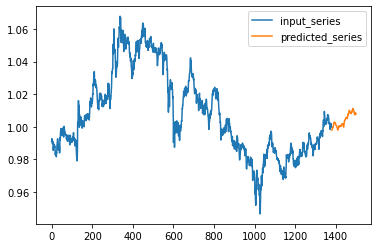

In [ ]:
plot_predicted_series(x_test_close[0,:], predicted[0,:])

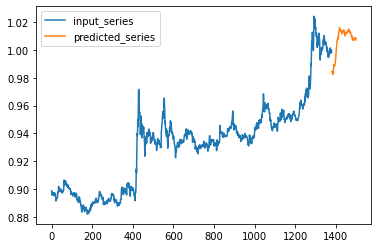

In [ ]:
plot_predicted_series(x_test_close[1,:], predicted[1,:])

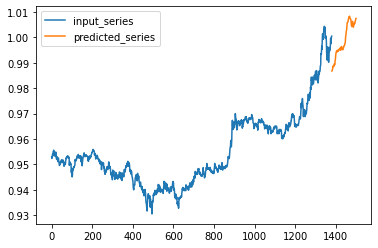

In [ ]:
plot_predicted_series(x_test_close[2,:], predicted[2,:])

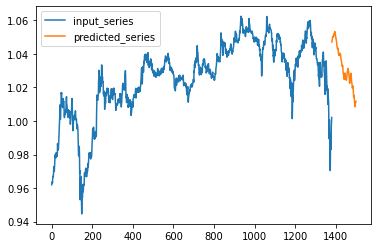

In [ ]:
plot_predicted_series(x_test_close[3,:], predicted[3,:])

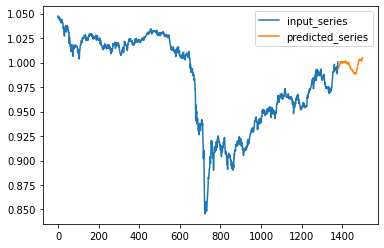

In [ ]:
plot_predicted_series(x_test_close[4,:], predicted[4,:])

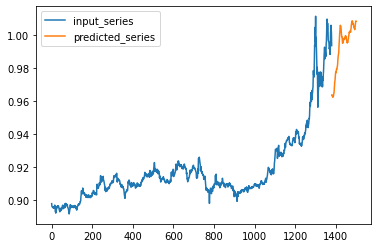

In [ ]:
plot_predicted_series(x_test_close[5,:], predicted[5,:])

# Plot predictions for train for comparison

In [ ]:
X.shape

(10112520, 60, 1)

In [ ]:
predicted_train = best_gru.predict(X[:2400, :])


In [ ]:
predicted_train = predicted_train.reshape((-1,120)) 

predicted_train.shape

(20, 120)

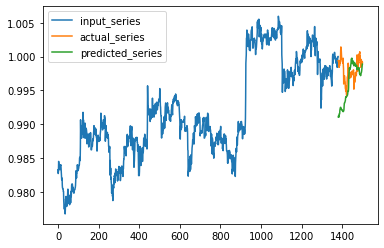

In [ ]:
plot_series(x_train_close[0,:], y_train_close[0,:], predicted_train[0,:])

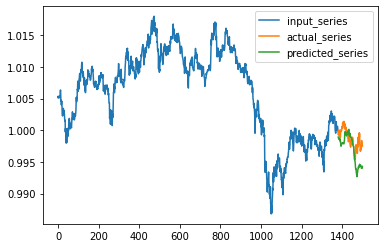

In [ ]:
plot_series(x_train_close[1,:], y_train_close[1,:], predicted_train[1,:])

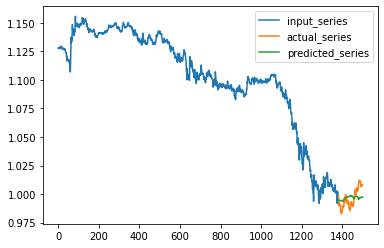

In [ ]:
plot_series(x_train_close[2,:], y_train_close[2,:], predicted_train[2,:])

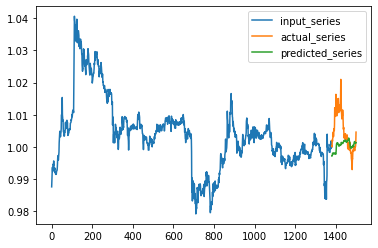

In [ ]:
plot_series(x_train_close[3,:], y_train_close[3,:], predicted_train[3,:])

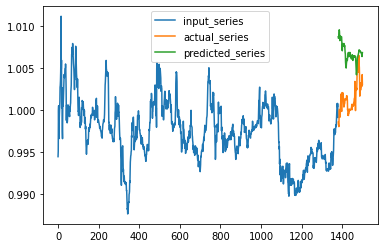

In [ ]:
plot_series(x_train_close[10,:], y_train_close[10,:], predicted_train[10,:])